In [73]:
import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import create_paths
from create_paths import smoothen_paths
# from create_paths import mat_to_path
import matplotlib.pyplot as plt

import importlib.util
import sys

Configure the evaluation run

In [74]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_grad_enabled(False)

DATA_DIR = 'inputs' # the root directory containing the processed input data
DATASET = 'complex_map'      # (String) The name of the dataset to load. Leave as None to use the same dataset that the model was trained on.
SUBSET = 'eval'     # The name of the subset to load from

RUN_NAME = 'fragrant-donkey-87'
STEP = 75

BATCH_SIZE = 50
SMOOTH_VAL = 8

NUM_SAMPLES = 10     # the number of example outputs to generate
FIG_SCALE = 20      # the number of pixels per inch in the generated plots

Import the gan's class definitions

In [75]:
model_path = os.path.join(os.getcwd(), 'checkpoints', RUN_NAME, 'GAN.py')
if not os.path.isfile(model_path):
    print(f"ERROR: The model's class definitions are not saved at {model_path}")
    sys.exit(1)

# From https://docs.python.org/3/library/importlib.html#importing-a-source-file-directly
spec = importlib.util.spec_from_file_location('GAN', model_path)
module = importlib.util.module_from_spec(spec)
sys.modules['GAN'] = module
spec.loader.exec_module(module)

In [76]:
def path_to_tensor(path, map_dim):
    path_mat = torch.zeros(map_dim)

    # Make the path continuous
    for i in range(path.shape[0] - 1):
        x = int(path[i,1])
        x1 = int(path[i,1])
        x2 = int(path[i+1,1])

        y = int(path[i,0])
        y1 = int(path[i,0])
        y2 = int(path[i+1,0])

        if (x1 < x2):
            x_dir = 1
        else:
            x_dir = -1

        if (y1 < y2):
            y_dir = 1
        else:
            y_dir = -1

        # Determine y from x
        if x2-x1 != 0:
            m = (y2-y1)/(x2-x1)
            while x != x2:
                y = round(m*(x-x1) + y1)
                path_mat[y,x] = 1
                x += x_dir
        else:
            while x != x2:
                path_mat[y1,x] = 1
                x += x_dir


        x = int(path[i,1])
        x1 = int(path[i,1])
        x2 = int(path[i+1,1])

        y = int(path[i,0])
        y1 = int(path[i,0])
        y2 = int(path[i+1,0])

        # Determine x from y
        if y2-y1 != 0:
            m = (x2-x1)/(y2-y1)
            while y != y2:
                x = round(m*(y-y1) + x1)
                path_mat[y,x] = 1
                y += y_dir
        else:
            while y != y2:
                path_mat[y,x1] = 1
                y += y_dir
        
    path_mat[int(path[path.shape[0]-1,0]), int(path[path.shape[0]-1,1])] = 1     # Include the last point in the path

    return torch.tensor(path_mat)

Load the network(s)

In [77]:
from GAN import Generator

model = torch.load(f'checkpoints/{RUN_NAME}/gen/step_{STEP}.tar')

config = model['config']
gen = Generator(config['features_gen'], config['kernels_gen'], config['stride_gen'], config['padding_gen'], device=DEVICE)

gen.load_state_dict(model['state'])
if DATASET == None:
    DATASET = model['dataset']

Get the input set

In [78]:
# Make sure inputs exist for the desired dataset
input_dir = os.path.join(os.getcwd(), DATA_DIR, DATASET, SUBSET, 'paths')
map_dir = os.path.join(os.getcwd(), DATA_DIR, DATASET, SUBSET, 'maps')
if not os.path.isdir(input_dir):
    print(f'ERROR: {input_dir} is not a valid directory')
    sys.exit(1)
if not os.path.isdir(map_dir):
    print(f'ERROR: {map_dir} is not a valid directory')
    sys.exit(2)

# Load all inputs
inputs = []
maps = []
truth = os.scandir(input_dir)
for item in truth:
    maps.append(np.asarray(torch.load(os.path.join(map_dir, item.name))))
    true_item = torch.load(os.path.join(input_dir, item))
    inputs.append(true_item)

dataloader = DataLoader(inputs, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)

Get the resulting outputs

In [79]:
outputs = torch.Tensor()
for item_idx, item in enumerate(dataloader):
    item = item.to(DEVICE)

    # Generate some fake paths
    noise = torch.rand_like(item[:,0:1,:,:])
    noise = torch.cat((noise, item[:,1:,:,:]), axis=1)
    fake = gen(noise)

    out = torch.flip(item, [1])     # map, endpoints, truth
    out = torch.cat((out, fake), axis=1)  # map, endpoints, truth, generated (raw)

    out = out.to('cpu')
    outputs = torch.cat((outputs, out), axis=0)

# Channels: map, endpoints, ground truth, generated (raw)
outputs = outputs[:NUM_SAMPLES,:,:,:]
maps = maps[:NUM_SAMPLES]

round outputs using Rachael's code

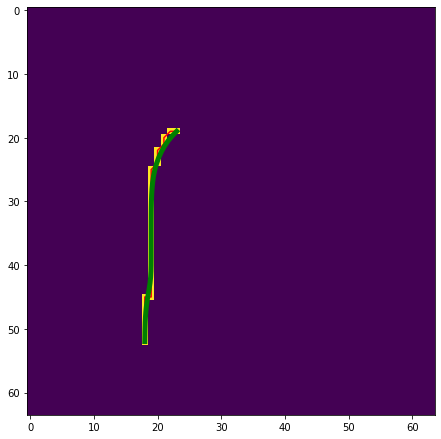

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


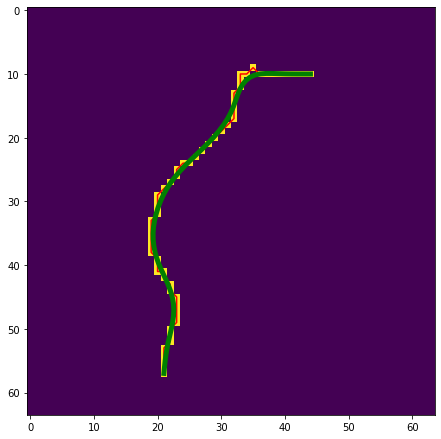

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


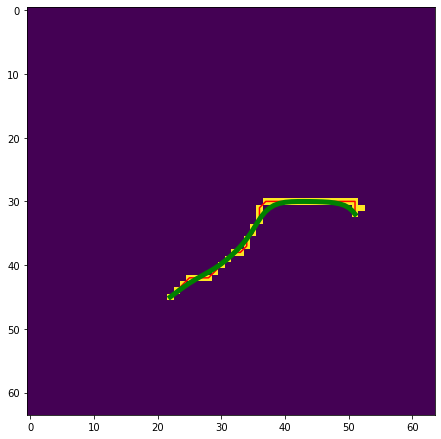

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


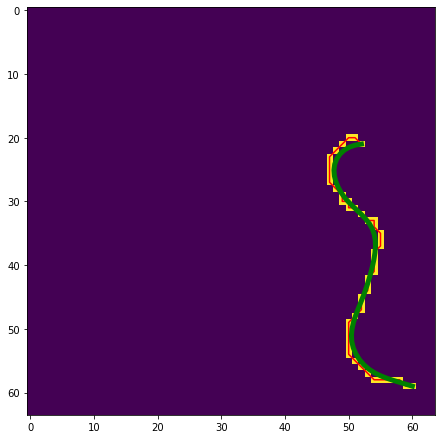

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


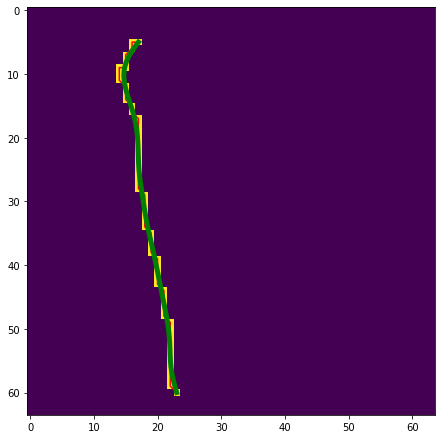

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


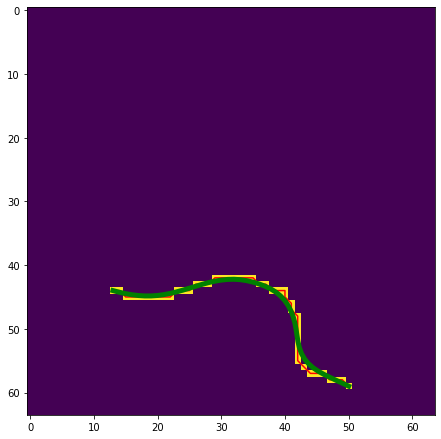

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


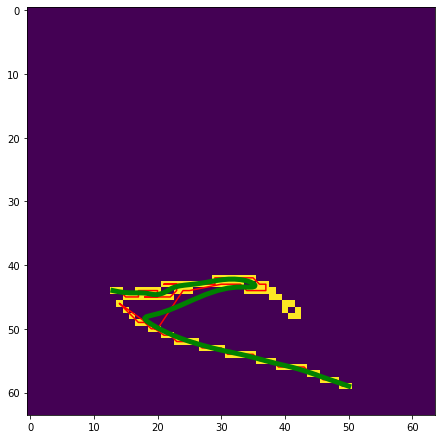

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


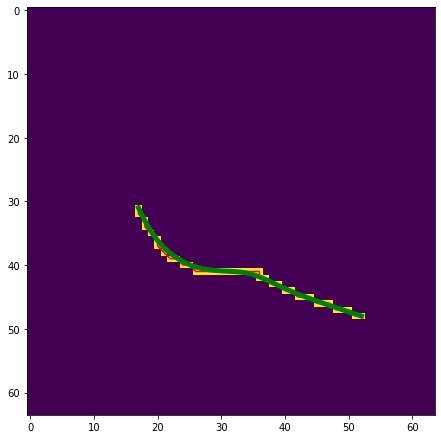

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


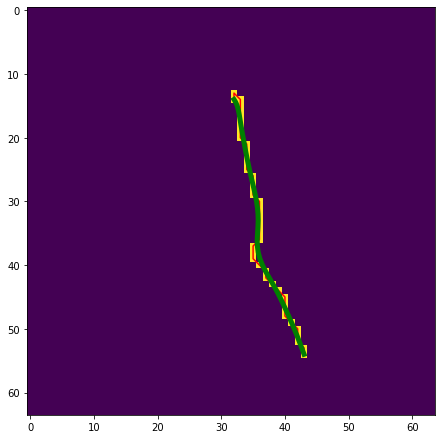

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


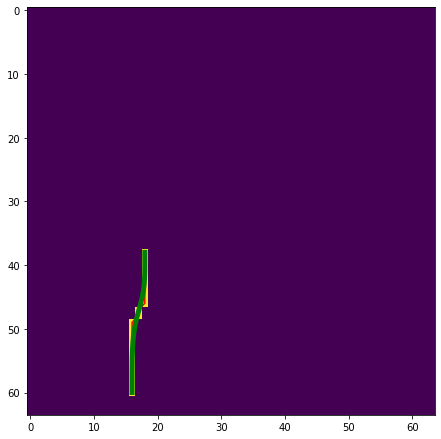

/tmp/ipykernel_17405/3734535675.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(path_mat)


In [82]:
# For each item, find start/end points using direct path (where direct path == 2)
outputs = torch.tensor(outputs)
smooth = torch.zeros_like(outputs[:,-1:,:,:])
for i in range(outputs.shape[0]):
    # Find start/end
    ends = torch.nonzero(outputs[i,1,:,:] > 1)
    # ends = torch.flip(ends, [0])

    smooth[i] = path_to_tensor(smoothen_paths(outputs[i,-1:,:,:], ends[0], ends[1], smooth_val=SMOOTH_VAL, display=True)[0], outputs[i,-1,:,:].shape)[None,None,:,:]


outputs = torch.cat((outputs, smooth), axis=1)

# Channels: map, endpoints, ground truth, generated (raw), generated (smooth)

Format and save input, raw output, and rounded path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

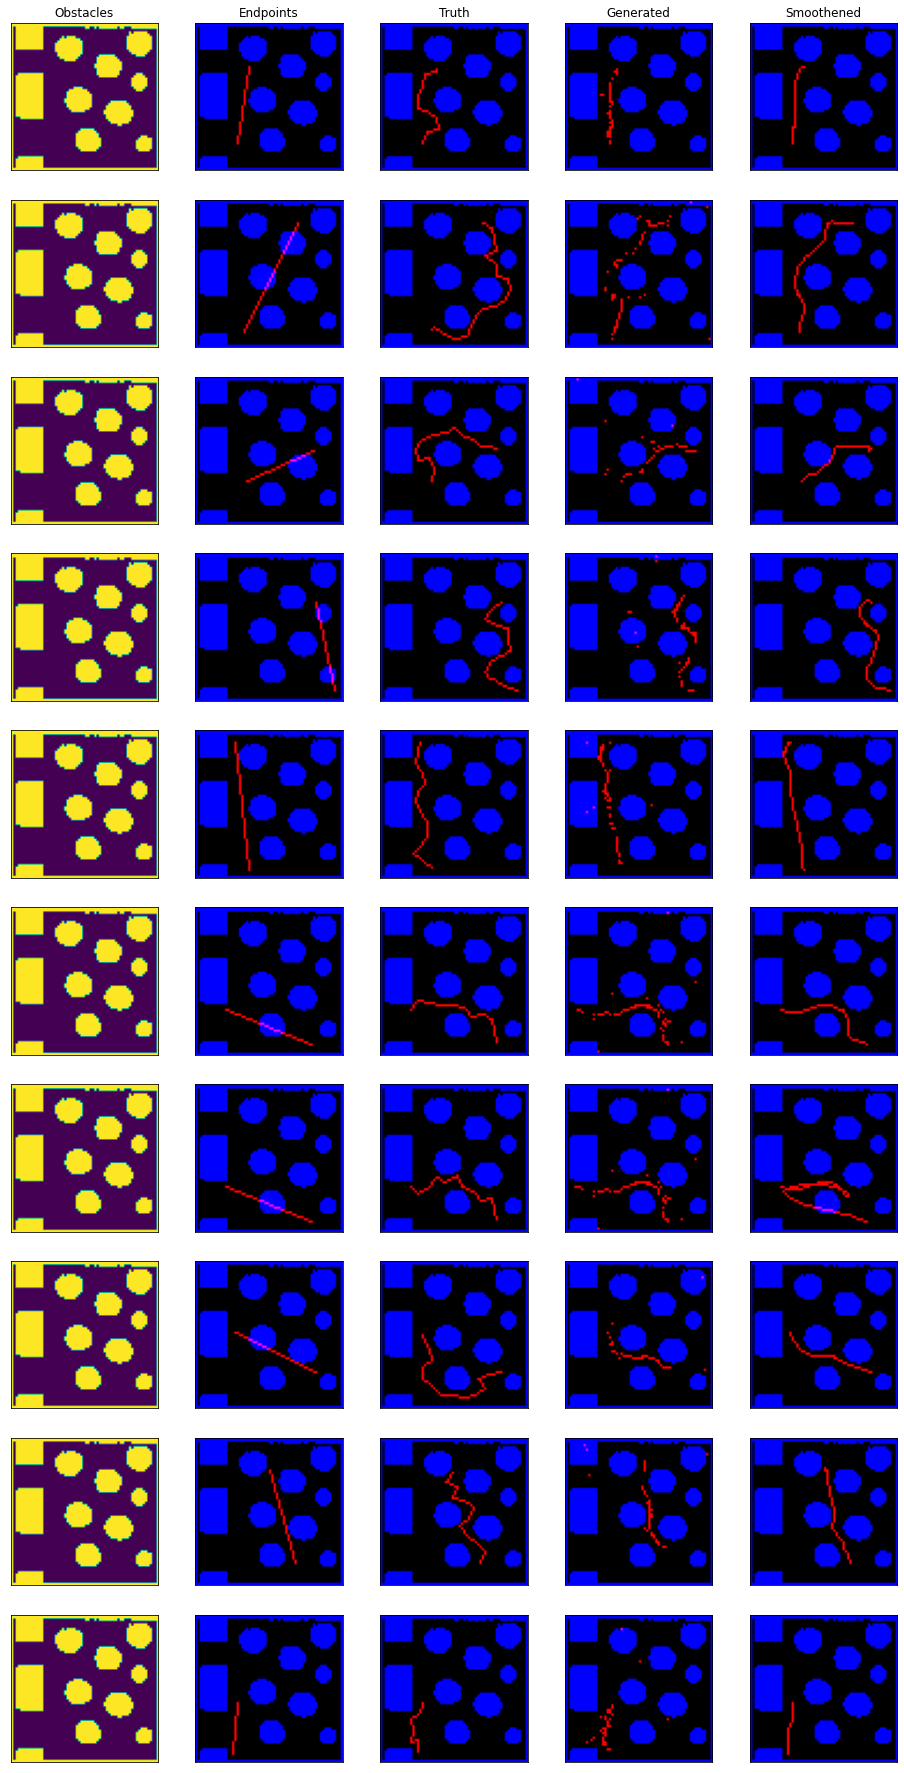

In [81]:
outputs = np.asarray(outputs)

fig = plt.figure(figsize=(max(5, 5*outputs[0,0,:,:].shape[1]/FIG_SCALE),max((5/5)*NUM_SAMPLES, NUM_SAMPLES*outputs[0,0,:,:].shape[0]/FIG_SCALE)))

col_title = True
for i in range(NUM_SAMPLES):
    sub = fig.add_subplot(NUM_SAMPLES,5,i*5+1)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(maps[i])
    if col_title:
        plt.title('Obstacles')

    # TODO: remove endpoints column, plot endpoints on other subplots
    sub = fig.add_subplot(NUM_SAMPLES,5,i*5+2)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(np.stack((outputs[i,1,:,:], np.zeros_like(outputs[i,1,:,:]), maps[i]), axis=-1))
    if col_title:
        plt.title('Endpoints')

    sub = fig.add_subplot(NUM_SAMPLES,5,i*5+3)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(np.stack((outputs[i,2,:,:], np.zeros_like(outputs[i,2,:,:]), maps[i]), axis=-1))
    if col_title:
        plt.title('Truth')

    sub = fig.add_subplot(NUM_SAMPLES,5,i*5+4)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(np.stack((outputs[i,3,:,:], np.zeros_like(outputs[i,3,:,:]), maps[i]), axis=-1))
    if col_title:
        plt.title('Generated')

    sub = fig.add_subplot(NUM_SAMPLES,5,i*5+5)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(np.stack((outputs[i,-1,:,:], np.zeros_like(outputs[i,4,:,:]), maps[i]), axis=-1))
    if col_title:
        plt.title('Smoothened')

    col_title = False

plt.show()